<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/baseline_with_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_raw_withoutaug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_raw_withoutaug')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 이미지 노이즈

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 23989 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


### 모델 1_baseline1

In [ ]:
# 모델 구조 정의 
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(64,64,3), padding='same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding = 'same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# 전결합층
model1.add(Flatten())    # 벡터형태로 reshape
model1.add(Dense(512))   # 출력
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(33))
model1.add(Activation('softmax'))

# 모델 구축하기
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model1.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/base_raw_1/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
#earlystop=EarlyStopping(patience=7)

my_callbacks = [checkpoint,annealer]

In [ ]:
baseline1= model1.fit_generator(train_generator,
                               epochs=50,
                               validation_data=validation_generator,
                               callbacks=my_callbacks)

Epoch 1/50
374/375 [============================>.] - ETA: 5s - loss: 3.3312 - accuracy: 0.1332 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


375/375 [==============================] - 3231s 9s/step - loss: 3.3310 - accuracy: 0.1334 - val_loss: 3.3150 - val_accuracy: 0.1341

Epoch 00001: val_accuracy improved from -inf to 0.13406, saving model to /content/gdrive/My Drive/model_save/base_raw_1/01-3.3150.hdf5
Epoch 2/50
375/375 [==============================] - 81s 217ms/step - loss: 3.2701 - accuracy: 0.1358 - val_loss: 3.1923 - val_accuracy: 0.1344

Epoch 00002: val_accuracy improved from 0.13406 to 0.13443, saving model to /content/gdrive/My Drive/model_save/base_raw_1/02-3.1923.hdf5
Epoch 3/50
375/375 [==============================] - 83s 221ms/step - loss: 3.0647 - accuracy: 0.1795 - val_loss: 2.7301 - val_accuracy: 0.2365

Epoch 00003: val_accuracy improved from 0.13443 to 0.23645, saving model to /content/gdrive/My Drive/model_save/base_raw_1/03-2.7301.hdf5
Epoch 4/50
375/375 [==============================] - 82s 218ms/step - loss: 2.7523 - accuracy: 0.2480 - val_loss: 2.5674 - val_accuracy: 0.3248

Epoch 00004: val_

In [ ]:
model1.save('/content/gdrive/My Drive/model_save/base_raw_1/baseline1_raw.h5')

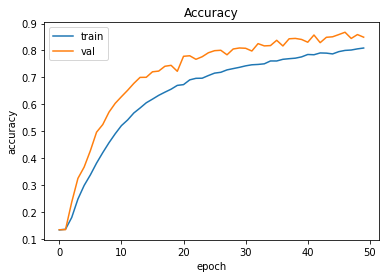

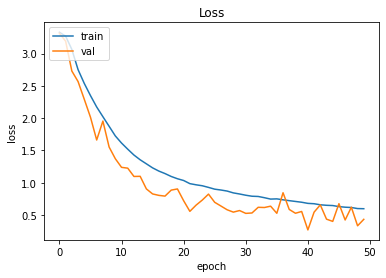

In [ ]:
# accuracy plot 
plt.plot(baseline1.history['accuracy'])
plt.plot(baseline1.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(baseline1.history['loss'])
plt.plot(baseline1.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

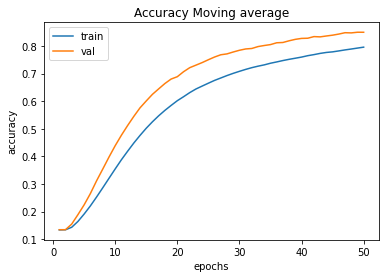

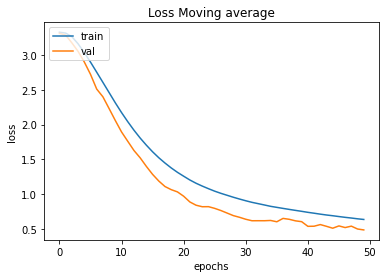

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(baseline1.history['accuracy'])
smooth_mae_history_val = smooth_curve(baseline1.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(baseline1.history['loss']))
plt.plot(smooth_curve(baseline1.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



###모델 2_baseline4



In [ ]:
# baseline_4 : 3이랑 똑같은데 dropout(0.25) 두개를 지워봄
# 모델 구조 정의 
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(64,64,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(64, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(128, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# 전결합층
model2.add(Flatten())    # 벡터형태로 reshape
model2.add(Dense(512))   # 출력
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(33))
model2.add(Activation('softmax'))

# 모델 구축하기
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model2.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/base_raw_2/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
#earlystop=EarlyStopping(patience=7)

my_callbacks = [checkpoint,annealer]

In [ ]:
baseline2= model2.fit_generator(train_generator,
                               epochs=50,
                               validation_data=validation_generator,
                               callbacks=my_callbacks)

Epoch 1/50
375/375 [==============================] - 84s 223ms/step - loss: 3.4458 - accuracy: 0.0869 - val_loss: 3.4069 - val_accuracy: 0.1341

Epoch 00001: val_accuracy improved from -inf to 0.13406, saving model to /content/gdrive/My Drive/model_save/base_raw_2/01-3.4069.hdf5
Epoch 2/50
375/375 [==============================] - 83s 222ms/step - loss: 3.3465 - accuracy: 0.1333 - val_loss: 3.2570 - val_accuracy: 0.1341

Epoch 00002: val_accuracy did not improve from 0.13406
Epoch 3/50
375/375 [==============================] - 81s 217ms/step - loss: 3.3158 - accuracy: 0.1336 - val_loss: 3.4107 - val_accuracy: 0.1341

Epoch 00003: val_accuracy did not improve from 0.13406
Epoch 4/50
375/375 [==============================] - 81s 217ms/step - loss: 3.2480 - accuracy: 0.1339 - val_loss: 3.1550 - val_accuracy: 0.1341

Epoch 00004: val_accuracy did not improve from 0.13406
Epoch 5/50
375/375 [==============================] - 81s 217ms/step - loss: 3.1645 - accuracy: 0.1376 - val_loss: 3

In [ ]:
model2.save('/content/gdrive/My Drive/model_save/base_raw_2/baseline2_raw.h5')

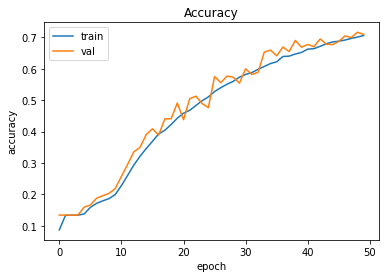

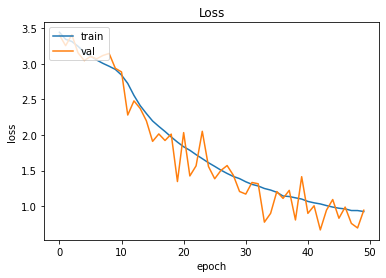

In [ ]:
# accuracy plot 
plt.plot(baseline2.history['accuracy'])
plt.plot(baseline2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(baseline2.history['loss'])
plt.plot(baseline2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

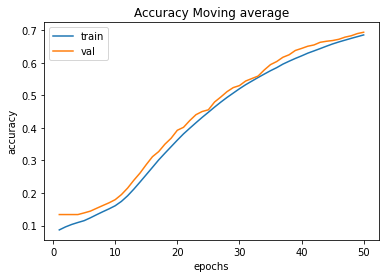

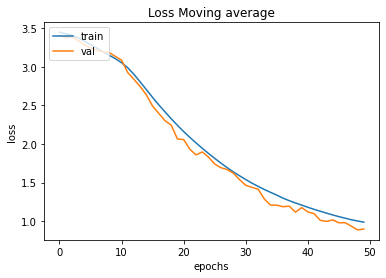

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(baseline2.history['accuracy'])
smooth_mae_history_val = smooth_curve(baseline2.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(baseline2.history['loss']))
plt.plot(smooth_curve(baseline2.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()